# Getting Started

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data and dataset modification

In [4]:
DATA_FOLDER = "../../data/"

PREPROCESSED_CHARACTER_DATASET = DATA_FOLDER+"preprocessed_character_metadata_2.tsv"
MOVIE_DATASET = DATA_FOLDER+"movie.metadata.tsv"

character_metadata = pd.read_csv(PREPROCESSED_CHARACTER_DATASET, sep='\t')
movies_column_names = ['Wikipedia_Movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
movies = pd.read_csv(MOVIE_DATASET, sep='\t', header=None,names=movies_column_names, decimal='.' )

We want to look at the character ethnicity representation depending on the country. Therefore, we can merge the character dataset with the column from the movie dataset containing the country of each film.  

In [5]:
character_countries = pd.merge(character_metadata,movies[['Wikipedia_Movie_ID', 'Movie_countries']], on = 'Wikipedia_Movie_ID')
character_countries.sample(5)

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_Ethnicity,Actor_Name,Actor_Age_At_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_character_ID,Freebase_Actor_ID,Movie_Release_Year,Ethnicity_Label,Movie_countries
18528,25470407,/m/09rslm9,NaN,/m/033tf_,Patrick Muldoon,40.0,/m/09sdgqb,NaN,/m/05lx42,2008.0,"['European', 'Croatian', 'Yugoslav', 'Central ...","{""/m/0d060g"": ""Canada""}"
50,12061267,/m/02vnj6h,Tina,/m/07hwkr,Laura Dern,19.0,/m/052c_q7,/m/0h2khs3,/m/09zmys,1987.0,"['European', 'Scandinavian', 'Western European...","{""/m/09c7w0"": ""United States of America""}"
5300,261364,/m/01mshx,Molay,/m/04lhn7b,Arnold Vosloo,40.0,/m/03jtfm3,/m/0bb9f2v,/m/053gn_,2003.0,"['African', 'European', 'South African', 'West...","{""/m/09c7w0"": ""United States of America"", ""/m/..."
5104,4968653,/m/0cxnx_,Constance de Bonacieux,/m/02wcbj_,Raquel Welch,34.0,/m/02vcr3q,/m/0gygj_6,/m/012s5j,1974.0,"['European', 'Spanish', 'South American', 'Bol...","{""/m/09c7w0"": ""United States of America"", ""/m/..."
9737,1968844,/m/069t4y,Larry,/m/041rx,Billy Crystal,39.0,/m/0k73q7,/m/0h2l7df,/m/01h1b,1987.0,"['European', 'Jewish', 'Asian', 'Russian', 'Ea...","{""/m/09c7w0"": ""United States of America""}"


## Actor ethnicity in the US vs Rest of the world

We want to analyze the impact of 9/11 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after 9/11. Moreover, we expect for 9/11 to have a higher impact in the US compared to the rest of the world. Therefore, we will compare the data on those levels.

In [6]:
character = character_countries.copy()
print("length of the dataset: ", len(character))

#Separation into 2 datasets, one with only movies form the US and the other that contaisn all the other movies

character_ROW = character.loc[~character['Movie_countries'].str.contains("United States of America")]
print("length of the ROW dataset: ", len(character_ROW))

character_US = character.loc[character['Movie_countries'].str.contains("United States of America")]
print("length of the US dataset: ", len(character_US))

#reset the index

character_ROW = character_ROW.reset_index(drop = True)
character_US = character_US.reset_index(drop = True)

length of the dataset:  18567
length of the ROW dataset:  1530
length of the US dataset:  17037


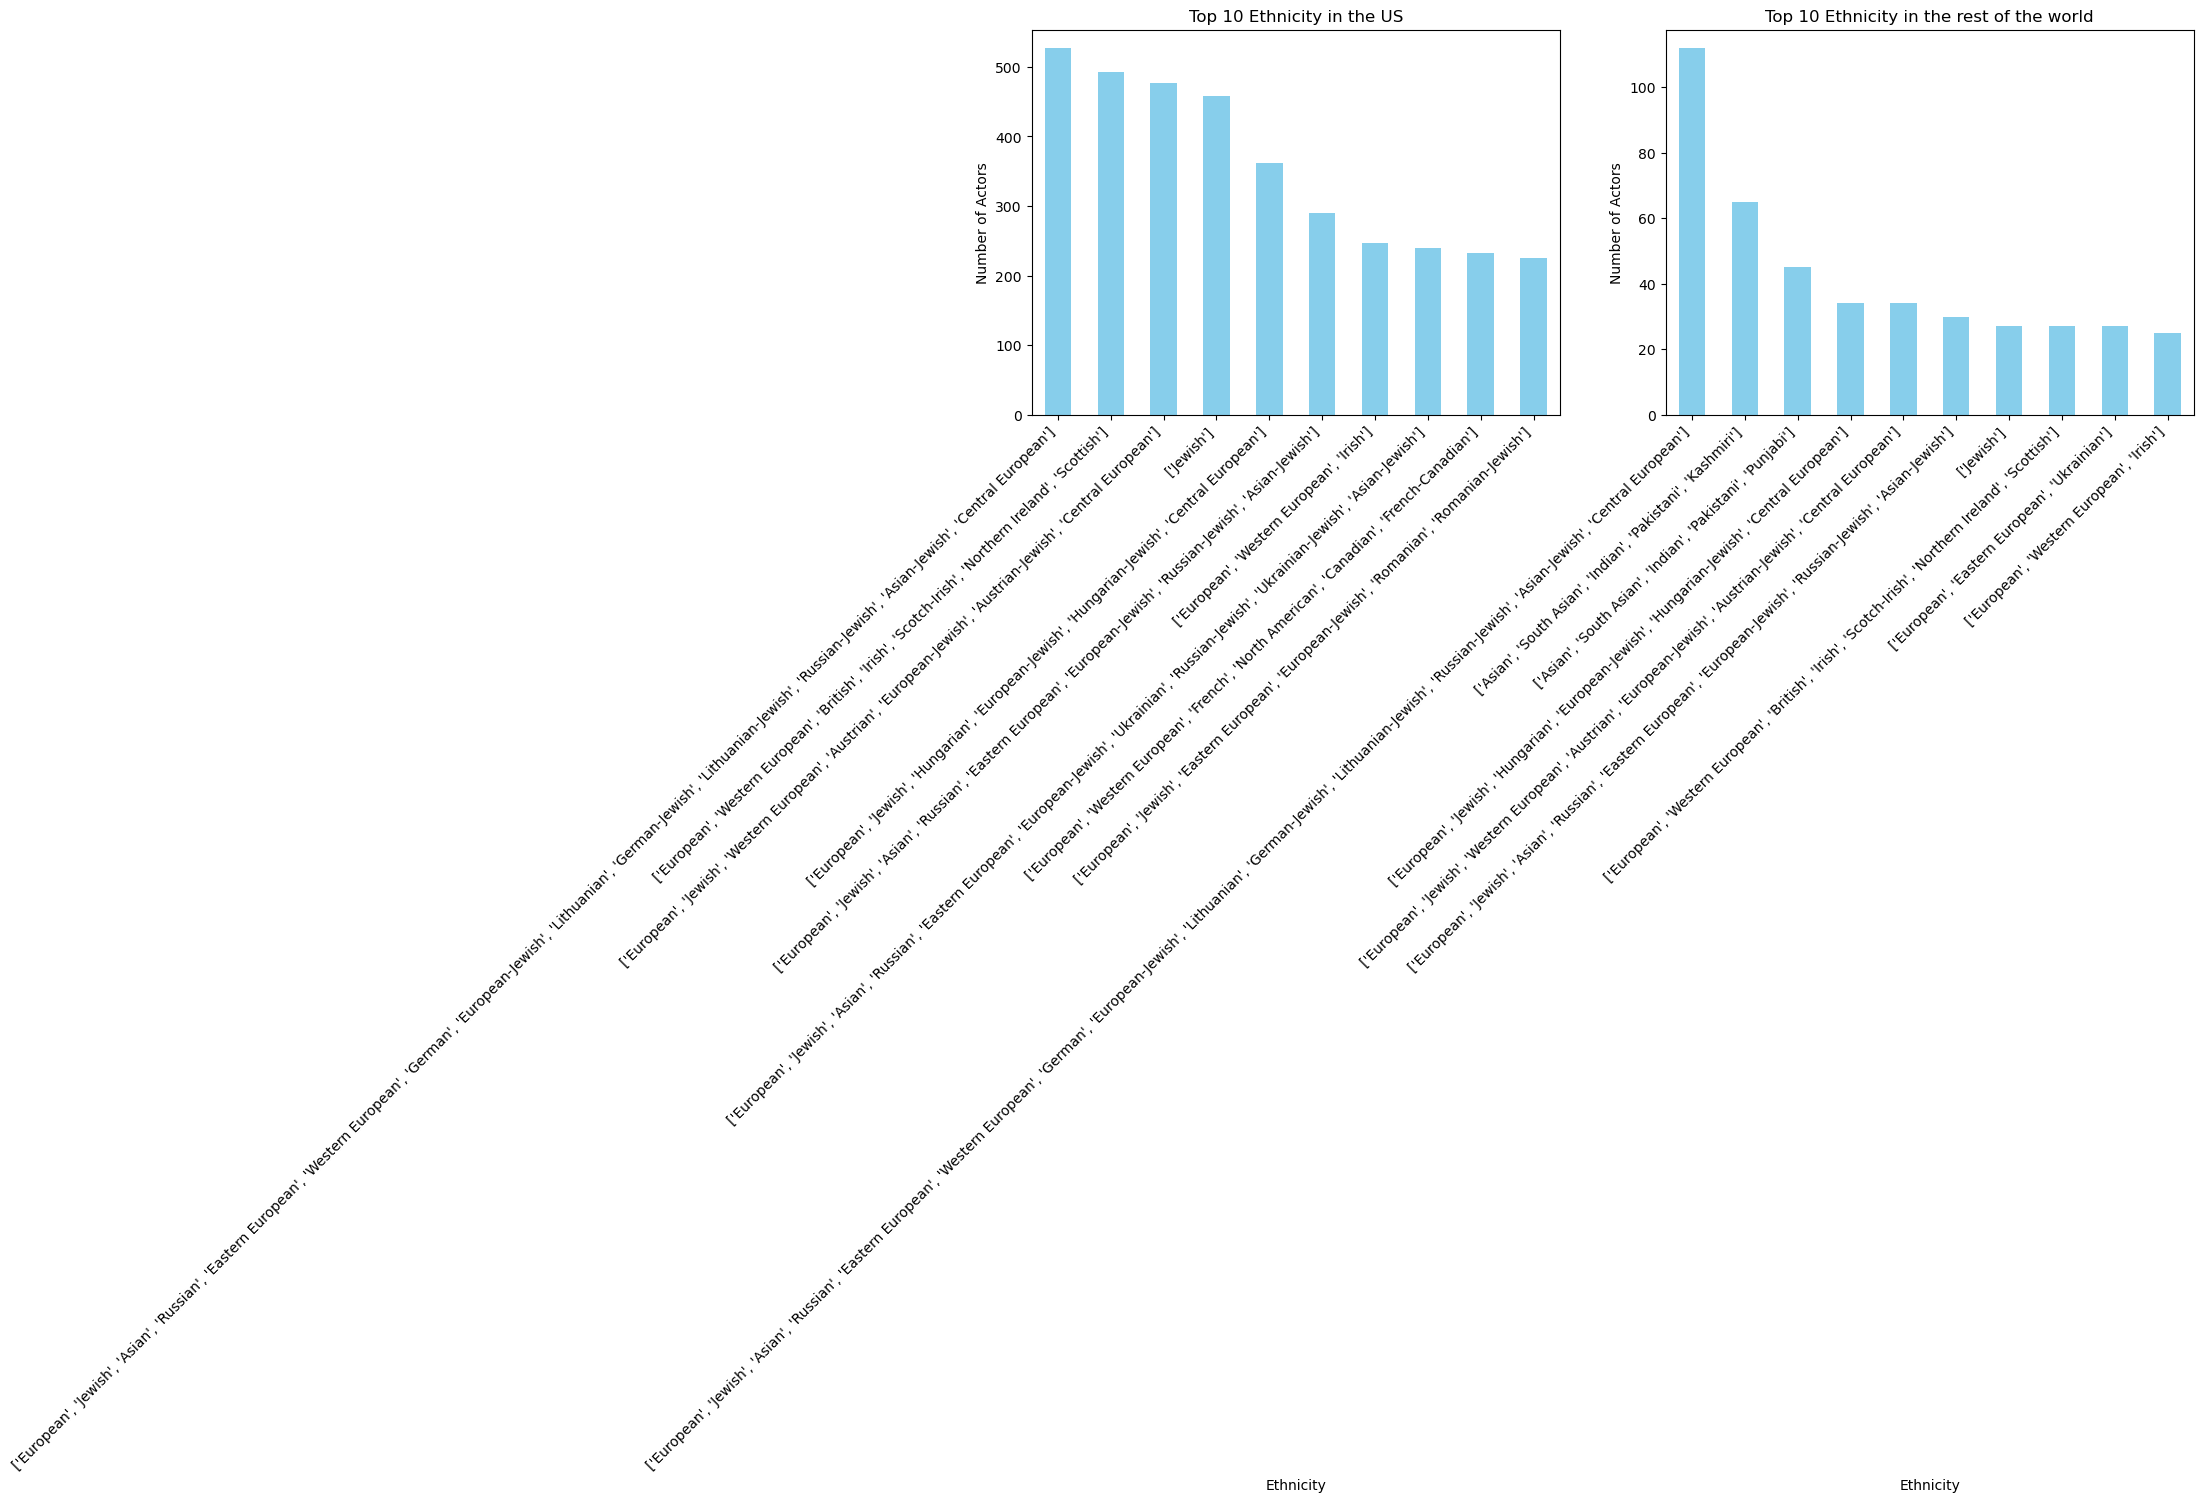

In [7]:
# Count the occurrences of each ethnicity
ethnicity_top10_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_US = character_US['Ethnicity_Label'].value_counts().nlargest(10)

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ethnicity_top10_US.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the US")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
ethnicity_top10_ROW.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the rest of the world")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
# plt.subplots_adjust(wspace=0.5)
plt.show()


We observe the top 10 ethnicty in the rest of the world differ from the top 10 ethnicty within the US. The African Americains is the most represented ethnicity in the US whereas in the rest of the world this is the indian. 

### The impact of 9/11

We will now deep into a reduce period of time, between 1993 and 2010 and observe the difference between ethnicities representation in the US compared to the rest of the world. 

In [8]:
# First for the US movies, we will filter the data for movies released between 1993 and 2001 and between 2002 and 2010,
# and study the most common ethnicities for these time periods.

#  Filter data for movies released between 1990 and 2001
data_1993_2001_US = character_US[(character_US['Movie_Release_Year'] >= 1993) & 
                                    (character_US['Movie_Release_Year'] <= 2001)]
data_2002_2010_US = character_US[(character_US['Movie_Release_Year'] >= 2002) & 
                                    (character_US['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_US = character_US['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_US = data_1993_2001_US[data_1993_2001_US['Ethnicity_Label'].isin(top_ethnicities_US)]
data_2002_2010_top_US = data_2002_2010_US[data_2002_2010_US['Ethnicity_Label'].isin(top_ethnicities_US)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_US = data_1993_2001_top_US['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_US = data_2002_2010_top_US['Ethnicity_Label'].value_counts(normalize=True)

We apply the same procedure for the rest of the world

In [9]:
#  Filter data for movies released between 1990 and 2001
data_1993_2001_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 1993) & 
                                    (character_ROW['Movie_Release_Year'] <= 2001)]
data_2002_2010_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 2002) &
                                    (character_ROW['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_ROW = data_1993_2001_ROW[data_1993_2001_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]
data_2002_2010_top_ROW = data_2002_2010_ROW[data_2002_2010_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_ROW = data_1993_2001_top_ROW['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_ROW = data_2002_2010_top_ROW['Ethnicity_Label'].value_counts(normalize=True)

We can now plot the proportion of actor among the 10 most represented ethnicities, for the US and the rest of the world, and compare to see whether there is a different distribution in the two time periods.

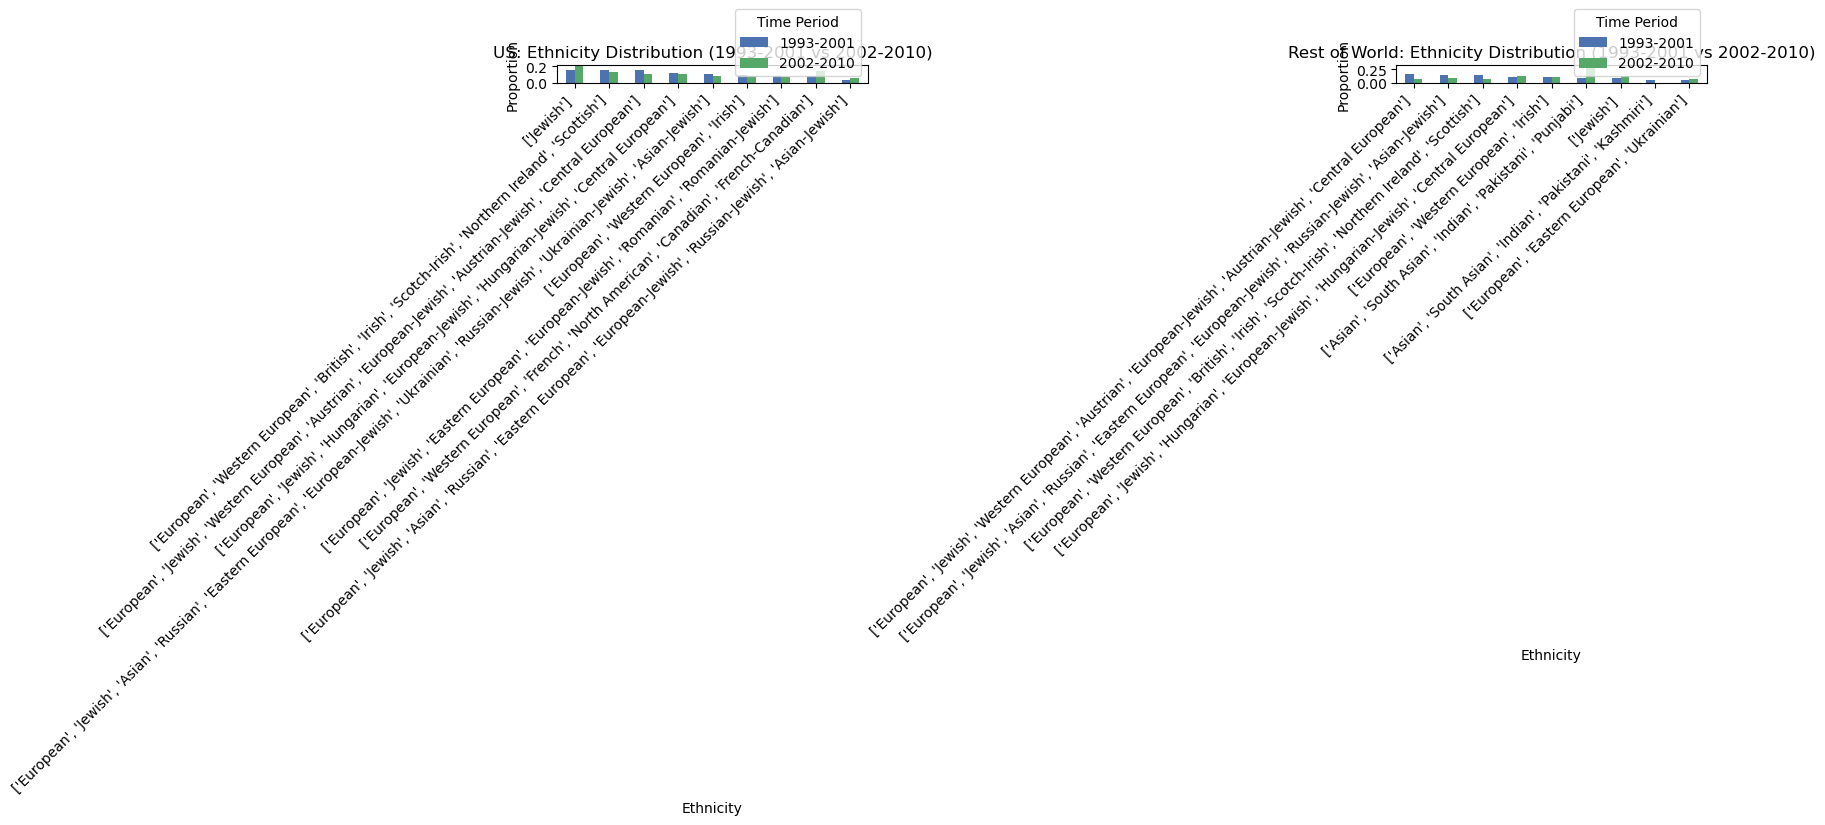

In [10]:

# Convert ethnicity counts to DataFrames for easier plotting
df_US = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_US.index,
    '1993-2001': ethnicity_counts_1993_2001_US.values,
    '2002-2010': ethnicity_counts_2002_2010_US.reindex(ethnicity_counts_1993_2001_US.index, fill_value=0).values
})

df_ROW = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_ROW.index,
    '1993-2001': ethnicity_counts_1993_2001_ROW.values,
    '2002-2010': ethnicity_counts_2002_2010_ROW.reindex(ethnicity_counts_1993_2001_ROW.index, fill_value=0).values
})

# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for US
df_US.set_index('Ethnicity').plot(
    kind='bar', ax=axes[0], color=['#4c72b0', '#55a868']
)
axes[0].set_title('US: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Ethnicity')
axes[0].legend(title="Time Period")
axes[0].set_xticklabels(df_US['Ethnicity'], rotation=45, ha="right")

# Plot for Rest of World
df_ROW.set_index('Ethnicity').plot(
    kind='bar', ax=axes[1], color=['#4c72b0', '#55a868']
)
axes[1].set_title('Rest of World: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Ethnicity')
axes[1].legend(title="Time Period")
axes[1].set_xticklabels(df_ROW['Ethnicity'], rotation=45, ha="right")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


We observe there is no major changes in the top 10 actor ethnciites representation in the movies between 1993 and 2010 neither in the rest of the world or the United States.

Finally, we want to isolate the actor ethnicities that exhibit major changes before and after 9/11. Therefore, we will look at the top 10  actor ethnicites that exxhibit larger relative changes ratio. 

In [11]:
# Count the occurrences of each ethnicity in each period for rest of the world and US 
ethnicity_counts_1993_2001_US = data_1993_2001_US['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_US = data_2002_2010_US['Ethnicity_Label'].value_counts()

ethnicity_counts_1993_2001_ROW = data_1993_2001_ROW['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_ROW = data_2002_2010_ROW['Ethnicity_Label'].value_counts()

# We compute the relative changes for each ethnicites between 1991 and 2011
#Use absolute value to avoid the negative value and for subsequnet isolation of smaller and largest relative difference 
ratio_US = np.abs(ethnicity_counts_1993_2001_US - ethnicity_counts_2002_2010_US) / (ethnicity_counts_1993_2001_US)
ratio_ROW = np.abs(ethnicity_counts_1993_2001_ROW - ethnicity_counts_2002_2010_ROW) / (ethnicity_counts_1993_2001_ROW)


# Sort by the ratio to find the largest 
largest_ratios_US = ratio_US.nlargest(10)
largest_ratios_ROW = ratio_ROW.nlargest(10)

print("US: 5 Largest Ratios: \n \n", largest_ratios_US)
print("\n \n Rest of the world: 5 Largest Ratios:\n \n", largest_ratios_ROW)

US: 5 Largest Ratios: 
 
 Ethnicity_Label
['European', 'Jewish', 'Asian', 'Russian', 'Eastern European', 'European-Jewish', 'Ukrainian', 'Russian-Jewish', 'Ukrainian-Jewish', 'North American', 'Canadian', 'Asian-Jewish']    23.0
['European', 'Jewish', 'Western European', 'French']                                                                                                                                  16.0
['European', 'Western European', 'British', 'French']                                                                                                                                 15.0
['European', 'Scandinavian', 'Western European', 'British', 'Danish', 'German', 'South American', 'Argentine', 'Central European', 'English', 'Scottish']                             10.0
['Caribbean', 'European', 'Cuban', 'Western European', 'French', 'Italian', 'Swiss', 'North American', 'South American', 'Colombian', 'Central European', 'Southern European']         9.0
['European', 'Scandinav

We observe ratios larger than 1 meaning they exhibit significant differences between the 2 observed periods, i.e before and after 9/11. From this first analysis, we do not observe any tendency of impact of 9/11 on racism. 